# Multivariate approch
# This file contains the multivariate approach using stepwise and piecewise function. Note that in some cases the monotonically increasing constraint may not be satisfied, therefore, it needs more study. 

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import cvxpy as cp
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Stepwise multivariate
data = pd.read_csv('Greece_EQ_Euro_wDS_AIR_CT19.csv', sep=',')
train, test = train_test_split(data, test_size=0.2, random_state=42)
train = train.loc[train.Longitude.between(19, 31, inclusive="both") & train.Latitude.between(34, 43, inclusive="both")].reset_index()
test = test.loc[test.Longitude.between(19, 31, inclusive="both") & test.Latitude.between(34, 43, inclusive="both")].reset_index()

general_X = train[['Magnitude', 'FocalDepth', 'Longitude', 'Latitude']]
general_y = train['Loss']

general_reg = LinearRegression()
general_reg.fit(general_X, general_y)

test['predicted_loss'] = 0
x, xmax, resolution = 19, 31, 1
y, ymax = 34, 43

numbers = 1
layers = 0
m_step = 0.5 # Step for magntude
d_step = 20 # Step for depth

while x + resolution <= xmax:
    while y + resolution <= ymax:
        auxtrain = train.loc[train.Longitude.between(x, x + resolution, inclusive="left") & train.Latitude.between(y,y + resolution, inclusive="left")].reset_index()
        auxtest = test.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y, y + resolution, inclusive="left")].reset_index()

        if auxtrain.Loss.count() < 10 and auxtest.Loss.count() != 0:
            prediction = general_reg.predict(auxtest[['Magnitude', 'FocalDepth', 'Longitude', 'Latitude']])
            test.predicted_loss.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y, y + resolution, inclusive="left")] = prediction
        elif auxtest.Loss.count() != 0:
            m_bands = int(4 / m_step)
            d_bands = int(200 / d_step)
            A = np.zeros((auxtrain.shape[0], m_bands + d_bands), np.int8)
            A = pd.DataFrame(A)
            A = A.join(auxtrain[['Magnitude','FocalDepth']])
            b = np.array(auxtrain['Loss'])
            a = 5
            n = 0
            while a < 9:
                if len(A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')]) > 0:
                    A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')] = 1
                n += 1
                a += m_step
            a = 0
            while a < 200:
                if len(A.iloc[:, n].loc[A['FocalDepth'].between(a, a + d_step, inclusive='left')]) > 0:
                    A.iloc[:, n].loc[A['FocalDepth'].between(a, a + d_step, inclusive='left')] = 1
                n += 1
                a += d_step

            A = np.array(A.drop(['Magnitude','FocalDepth'], axis=1))
            C = np.zeros((m_bands + d_bands, m_bands + d_bands))
            
            # Monotonically increasing constraint for Magnitude
            for n in range(m_bands-1):
                C[n][n]=-1
                C[n][n+1]=1
                
            # Monotonically decreasing constraint for Depth
            for n in range(m_bands, m_bands + d_bands - 1):
                C[n][n] = 1
                C[n][n + 1] = -1

            m = cp.Variable(m_bands + d_bands)
            objective = cp.Minimize(cp.sum_squares(A @ m - b))
            constraints = [0 <= C @ m]
            prob = cp.Problem(objective, constraints)
            result = prob.solve()
            
            # Check and force the constraints
            for i in range(m_bands-1):
                if m.value[i]>m.value[i+1]:
                    m.value[i+1]=m.value[i]
            
            for i in range(m_bands , m_bands + d_bands-1):
                if m.value[i]<m.value[i+1]:
                    m.value[i+1]=m.value[i]            
            
            # Make predictions on test data
            T = np.zeros((auxtest.shape[0], m_bands + d_bands), np.int8)
            T = pd.DataFrame(T)
            T = T.join(auxtest[['Magnitude','FocalDepth']])
            a = 5
            n = 0
            while a < 9:
                if len(T.iloc[:, n].loc[T['Magnitude'].between(a, a + 0.5, inclusive='left')]) > 0:
                    T.iloc[:, n].loc[T['Magnitude'].between(a, a + 0.5, inclusive='left')] = 1
                n += 1
                a += m_step

            a = 0
            while a < 200:
                if len(T.iloc[:, n].loc[T['FocalDepth'].between(a, a + d_step, inclusive='left')]) > 0:
                    T.iloc[:, n].loc[T['FocalDepth'].between(a, a + d_step, inclusive='left')] = 1
                n += 1
                a += d_step

            T = np.array(T.drop(['Magnitude','FocalDepth'], axis=1))
            test.predicted_loss.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y,
                y + resolution, inclusive="left")] = T @ m.value
            numbers += 1
        layers += 1
        y += resolution
    y = 32
    #print(x)
    x += resolution

result = test[['predicted_loss']]
test.predicted_loss.loc[test['predicted_loss'] < 0] = 0
MSE = (test.predicted_loss - test.Loss) * (test.predicted_loss - test.Loss)
print('MSE:', MSE.mean())
print('RMSE:', math.sqrt(MSE.mean()))
print("Number of equations", numbers)
print("Number of layers", layers)

MSE: 2.7655802950649715e+17
RMSE: 525887848.79144824
Number of equations 108
Number of layers 130


MSE: 2.3618794134958678e+17
RMSE: 485991709.1366753
Number of equations 108
Number of layers 130


Text(0, 0.5, 'Loss')

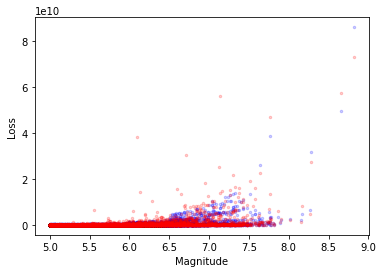

In [21]:
# Piecewise multivariate

data = pd.read_csv('Greece_EQ_Euro_wDS_AIR_CT19.csv', sep=',')
train, test = train_test_split(data, test_size=0.2, random_state=42)
train = train.loc[train.Longitude.between(19, 31, inclusive="both") & train.Latitude.between(34, 43, inclusive="both")].reset_index()
test = test.loc[test.Longitude.between(19, 31, inclusive="both") & test.Latitude.between(34, 43, inclusive="both")].reset_index()

general_X = train[['Magnitude', 'FocalDepth', 'Longitude', 'Latitude']]
general_y = train['Loss']

general_reg = LinearRegression()
general_reg.fit(general_X, general_y)

test['predicted_loss'] = 0
x, xmax, resolution = 19, 31, 1
y, ymax = 34, 43

numbers = 1
layers = 0
m_step = 0.5 # Step for magntude
d_step = 20 # Step for depth

while x + resolution <= xmax:
    while y + resolution <= ymax:
        auxtrain = train.loc[train.Longitude.between(x, x + resolution, inclusive="left") & train.Latitude.between(y,y + resolution, inclusive="left")].reset_index()
        auxtest = test.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y, y + resolution, inclusive="left")].reset_index()

        if auxtrain.Magnitude.count() < 10 and auxtest.Magnitude.count() != 0:
            prediction = general_reg.predict(auxtest[['Magnitude', 'FocalDepth', 'Longitude', 'Latitude']])
            test.predicted_loss.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y, y + resolution, inclusive="left")] = prediction
        elif auxtest.Magnitude.count() != 0:
            
            m_bands = int(4 / m_step)
            d_bands = int(200 / d_step)
            A = np.zeros((auxtrain.shape[0], m_bands * 2 + d_bands), np.int8)
            A = pd.DataFrame(A)
            A = A.join(auxtrain[['Magnitude','FocalDepth']])
            b = np.array(auxtrain['Loss'])
            a = 5
            n = 0
            
            # Check which band the magnitude belongs
            while a < 9:
                if len(A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')]) > 0:
                    A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')] = A['Magnitude'].loc[
                        A['Magnitude'].between(a, a + m_step, inclusive='left')]
                n += 1
                a += m_step
            a = 5
            
            # Set the y_intercept for A matrix
            while a < 9:
                if len(A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')]) > 0:
                    A.iloc[:, n].loc[A['Magnitude'].between(a, a + m_step, inclusive='left')] = 1
                n += 1
                a += m_step

            # Check which band the depth belongs
            a = 0
            while a < 200:
                if len(A.iloc[:, n].loc[A['FocalDepth'].between(a, a + d_step, inclusive='left')]) > 0:
                    A.iloc[:, n].loc[A['FocalDepth'].between(a, a + d_step, inclusive='left')] = 1
                n += 1
                a += d_step

            A = np.array(A.drop(['Magnitude','FocalDepth'], axis=1))
            
            # Set the monotonically increasing constraints
            C = np.zeros((m_bands * 2 + d_bands, m_bands * 2 + d_bands))
            mag=5
            for n in range(m_bands-1):
                C[n][n]=-mag
                C[n][n+1]=mag
                C[n][n+m_bands]=-1
                C[n][n+m_bands+1]=1
                mag+=m_step
            mag = 5
            for n in range(m_bands * 2, m_bands * 2 + d_bands - 1):
                C[n][n] = 1
                C[n][n + 1] = -1

            m = cp.Variable(m_bands * 2 + d_bands)
            objective = cp.Minimize(cp.sum_squares(A @ m - b))
            constraints = [0 <= C @ m]
            prob = cp.Problem(objective, constraints)
            result = prob.solve()

            T = np.zeros((auxtest.shape[0], m_bands * 2 + d_bands), np.int8)
            T = pd.DataFrame(T)
            T = T.join(auxtest[['Magnitude','FocalDepth']])
            a = 5
            n = 0
            while a < 9:
                if len(T.iloc[:, n].loc[T['Magnitude'].between(a, a + 0.5, inclusive='left')]) > 0:
                    T.iloc[:, n].loc[T['Magnitude'].between(a, a + 0.5, inclusive='left')] = T['Magnitude'].loc[
                        T['Magnitude'].between(a, a + 0.5, inclusive='left')]
                n += 1
                a += m_step
            a = 5
            while a < 9:
                if len(T.iloc[:, n].loc[T['Magnitude'].between(a, a + m_step, inclusive='left')]) > 0:
                    T.iloc[:, n].loc[T['Magnitude'].between(a, a + m_step, inclusive='left')] = 1 
                n += 1
                a += m_step
            a = 0
            while a < 200:
                if len(T.iloc[:, n].loc[T['FocalDepth'].between(a, a + d_step, inclusive='left')]) > 0:
                    T.iloc[:, n].loc[T['FocalDepth'].between(a, a + d_step, inclusive='left')] = 1
                n += 1
                a += d_step

            T = np.array(T.drop(['Magnitude','FocalDepth'], axis=1))
            test.predicted_loss.loc[test.Longitude.between(x, x + resolution, inclusive="left") & test.Latitude.between(y,
                y + resolution, inclusive="left")] = T @ m.value
            numbers += 1
        layers += 1
        y += resolution
    y = 32
    #print(x)
    x += resolution

result = test[['predicted_loss']]
test.predicted_loss.loc[test['predicted_loss'] < 0] = 0
MSE = (test.predicted_loss - test.Loss) * (test.predicted_loss - test.Loss)
print('MSE:', MSE.mean())
print('RMSE:', math.sqrt(MSE.mean()))
print("Number of equations", numbers)
print("Number of layers", layers)
plt.plot(test['Magnitude'], test['predicted_loss'], 'bo', markersize=2.5, alpha=0.2)
plt.plot(test['Magnitude'], test['Loss'], 'ro', markersize=2.5, alpha=0.2)
plt.xlabel('Magnitude')
plt.ylabel('Loss')
#plt.savefig('Comparison of datas.pdf')